<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Final Project

In this notebook, I'm going to perform some EDA on a dataset of Amazon's  and build some random forest and linear regression models in order to try and predict corrected index true rank of Amazon products using independent variables such as Vendor types, BB Price, and product prices. 

Dataset is available here: https://www.propublica.org/datastore/dataset/amazon-pricing-algorithm-data-set

Some notable limitations we need to be made aware of: this is only the top 250 Amazon products from 2018. This gives us several limitations: Our findings might not apply to products outside of the top 250 products from that year, or even across other years. There could also be bias due to the fact we're only looking at the highest performing products. Our data also isn't including products from all industries, meaning our findings might not apply to those industries. Finally, a lot has changed since 2018. Amazon could have change how they rank and index their products since then, and the marketplace in general has changed. We will need to keep these limitations in mind moving forward. 

In [1]:
# Import everything we need for our project
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score

### Dataset EDA

In [2]:
# Load the dataset
amazon = pd.read_excel(
    "data/amazon.xlsx",
    names=[
        "Index",
        "ProductName",
        "ScrapeDate",
        "ScrapedIndex",
        "ScrapedIndexTrueRank",
        "CorrectedIndexTrueRank",
        "ScrapedIndexPrice",
        "CorrectedPrice",
        "ScrapedIndexVendor",
        "ScrapedIndexVendorType",
        "BBScrapedPrice",
        "BBVendorType",
        "BBVendor",
        "BBCorrectedPrice"
    ],
)

In [3]:
# Shows how many rows and columns there are in our dataset
amazon.shape

(6973, 14)

In [4]:
# Shows types of data
amazon.dtypes

Index                              int64
ProductName                       object
ScrapeDate                datetime64[ns]
ScrapedIndex                       int64
ScrapedIndexTrueRank               int64
CorrectedIndexTrueRank             int64
ScrapedIndexPrice                float64
CorrectedPrice                   float64
ScrapedIndexVendor                object
ScrapedIndexVendorType            object
BBScrapedPrice                   float64
BBVendorType                      object
BBVendor                          object
BBCorrectedPrice                 float64
dtype: object

In [5]:
# Shows how many null values there are 
amazon.isnull().sum()
# Luckily, in our case, we're not interested in the scraped index vendor or BB vendor,
# just vendor types, so we won't be using those columns. 
# We're not interested because those categories are too granular, and not 
# really helpful for answering our questions. 

Index                       0
ProductName                 0
ScrapeDate                  0
ScrapedIndex                0
ScrapedIndexTrueRank        0
CorrectedIndexTrueRank      0
ScrapedIndexPrice           0
CorrectedPrice              0
ScrapedIndexVendor          7
ScrapedIndexVendorType      0
BBScrapedPrice              0
BBVendorType                0
BBVendor                  164
BBCorrectedPrice            0
dtype: int64

In [6]:
# Look at first few rows of data
amazon.head()

,Index,ProductName,ScrapeDate,ScrapedIndex,ScrapedIndexTrueRank,CorrectedIndexTrueRank,ScrapedIndexPrice,CorrectedPrice,ScrapedIndexVendor,ScrapedIndexVendorType,BBScrapedPrice,BBVendorType,BBVendor,BBCorrectedPrice
0,0,#1 BEST Probiotic Supplement - 60 Day Supply w...,2016-06-14,2,2,1,20.99,20.99,Supplement Warriors,Other,-1.0,FBA,Sold by Sharp Nutrition and Fulfilled by Amazon.,25.02
1,1,#1 BEST Probiotic Supplement - 60 Day Supply w...,2016-06-14,1,1,2,19.99,25.02,Sharp Nutrition,FBA,-1.0,FBA,Sold by Sharp Nutrition and Fulfilled by Amazon.,25.02
2,2,"10 Panel Dip Drug Testing Kit, Test for 10 Dif...",2016-06-27,1,1,1,3.96,3.96,speedy tests,Other,4.9,FBA,Sold by Michael Minyety and Fulfilled by Amazon.,9.97
3,3,"10 Panel Dip Drug Testing Kit, Test for 10 Dif...",2016-06-27,2,1,1,3.96,3.96,Drug Abuse Control,Other,4.9,FBA,Sold by Michael Minyety and Fulfilled by Amazon.,9.97
4,4,"10 Panel Dip Drug Testing Kit, Test for 10 Dif...",2016-06-27,3,1,1,3.96,3.96,Lowest Priced Tests,Other,4.9,FBA,Sold by Michael Minyety and Fulfilled by Amazon.,9.97


In [7]:
# Describes our data for each column, showing things like mean and std
amazon.describe()

,Index,ScrapeDate,ScrapedIndex,ScrapedIndexTrueRank,CorrectedIndexTrueRank,ScrapedIndexPrice,CorrectedPrice,BBScrapedPrice,BBCorrectedPrice
count,6973.000000,6973,6973.000000,6973.000000,6973.000000,6973.000000,6973.000000,6973.000000,6973.000000
mean,3486.000000,2016-07-12 22:36:21.786892288,25.041876,22.730962,21.559300,54.904896,55.567631,36.295817,45.827961
min,0.000000,2016-06-07 00:00:00,1.000000,1.000000,1.000000,2.380000,2.380000,-1.000000,0.000000
25%,1743.000000,2016-06-17 00:00:00,8.000000,7.000000,7.000000,19.530000,20.010000,8.990000,15.790000
50%,3486.000000,2016-06-26 00:00:00,17.000000,16.000000,16.000000,31.900000,32.080000,14.940000,23.340000
75%,5229.000000,2016-08-29 00:00:00,35.000000,33.000000,31.000000,55.890000,56.100000,36.990000,47.920000
max,6972.000000,2016-09-06 00:00:00,162.000000,113.000000,107.000000,931.800000,931.800000,698.000000,706.110000
std,2013.076046,NaN,23.618871,20.520442,19.154709,74.293356,74.476092,61.838063,63.889925


- Plot the distribution of each column, e.g. with some combination of histograms, bar plots, and box plots.

Text(0.5, 1.0, 'Histogram for Corrected Price')

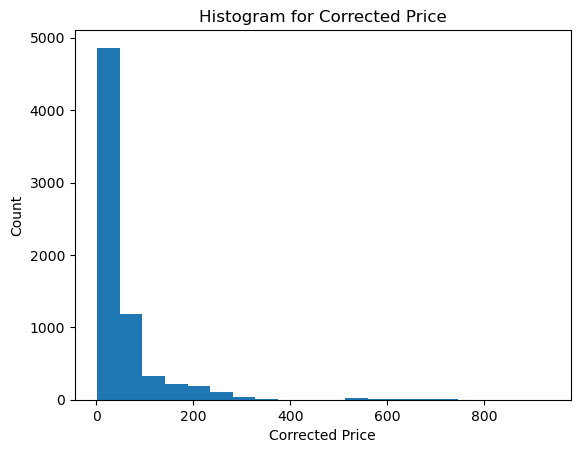

In [8]:
# Plots a histogram plot for Corrected Price
plt.hist(amazon['CorrectedPrice'], bins=20)
plt.xlabel('Corrected Price')
plt.ylabel('Count')
plt.title('Histogram for Corrected Price')

Text(0.5, 1.0, 'Histogram for BB Corrected Price')

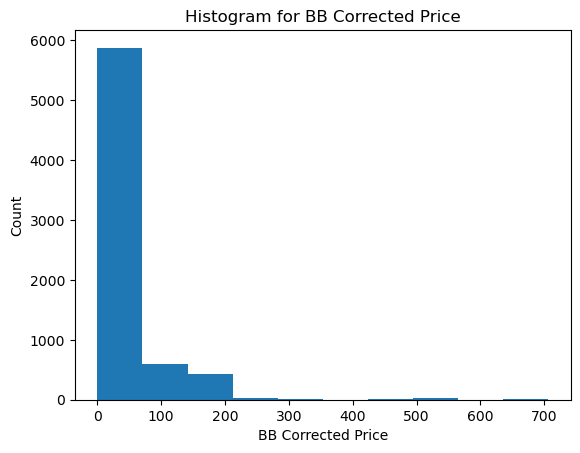

In [9]:
# Plots a box plot for BB Corrected Price
plt.hist(amazon['BBCorrectedPrice'], bins=10)
plt.xlabel('BB Corrected Price')
plt.ylabel('Count')
plt.title('Histogram for BB Corrected Price')

- Neither our BB Corrected price or Corrected Price are normally distributed. Both show strong skew. 

Text(0.5, 1.0, 'Number Amongst Vendor Types')

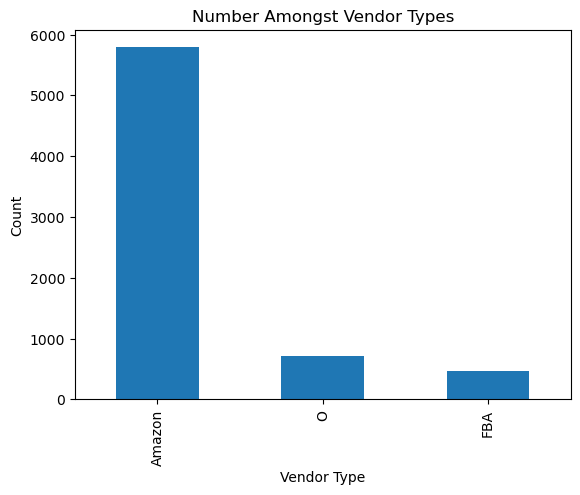

In [10]:
# Let's make a bar chart for BB vendor types
# Vendor types: Amazon, Fulfilled by Amazon (FBA), and Other (O- Neither our BB Corrected price or Corrected Price are normally distributed. Both show strong skew. )
BBVendorCount = amazon['BBVendorType'].value_counts()
BBVendorCount.plot(kind='bar')
plt.xlabel('Vendor Type')
plt.ylabel('Count')
plt.title('Number Amongst Vendor Types')

C:\Users\Paulm\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


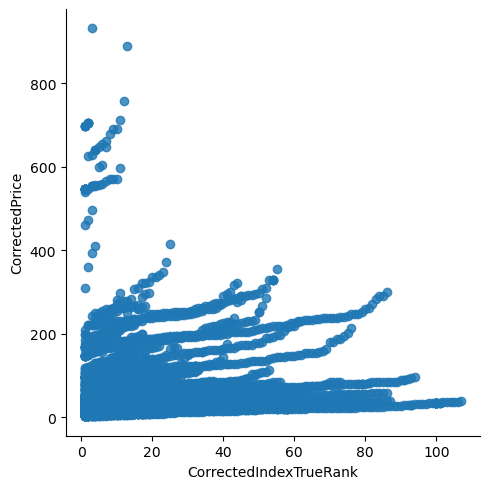

In [11]:
# We're going to make a scatterplot to get a quick overview of 
# price vs. our index rank.
sns.lmplot(x = 'CorrectedIndexTrueRank', y = 'CorrectedPrice', data=amazon, ci=None, fit_reg=False);

C:\Users\Paulm\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


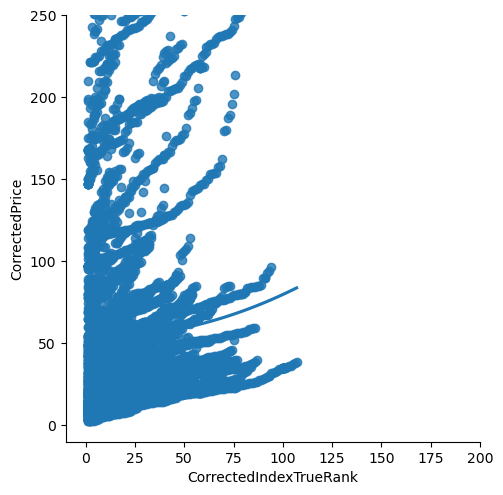

In [12]:
# Plotting our Corrected Price and Index True Rank but with a regression line
sns.lmplot(x='CorrectedIndexTrueRank', y='CorrectedPrice', data=amazon, ci=None, order=2);
plt.xlim(-10, 200);
plt.ylim(-10, 250);

C:\Users\Paulm\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


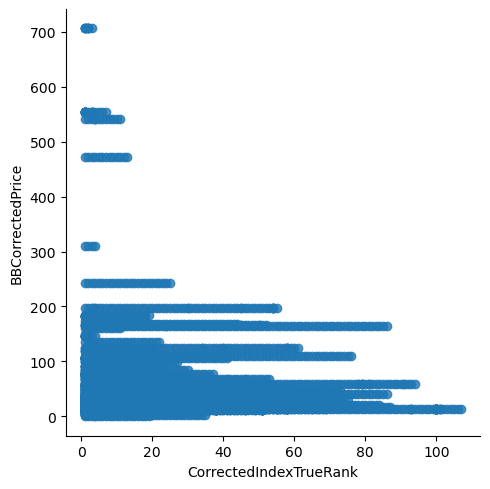

In [13]:
# We're going to make a scatterplot to get a quick overview of 
# BB price vs. our index rank.
sns.lmplot(x = 'CorrectedIndexTrueRank', y = 'BBCorrectedPrice', data=amazon, ci=None, fit_reg=False);

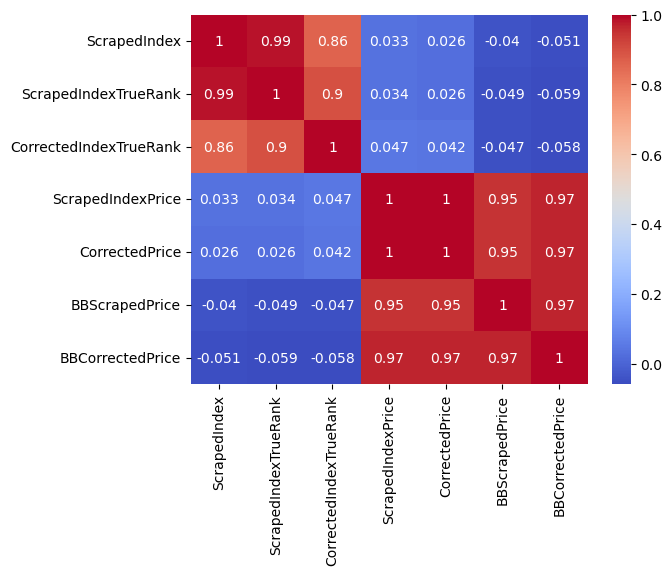

In [14]:
# Now we'll make a heatmap of all of our numerical columns
# We'll do this by making a version of our dataframe with just the numerical data
num_amazon = amazon[['ScrapedIndex', 'ScrapedIndexTrueRank', 'CorrectedIndexTrueRank', 'ScrapedIndexPrice', 'CorrectedPrice', 'BBScrapedPrice',
                    'BBCorrectedPrice']]
# Now we'll make a heatmap of our data:
sns.heatmap(num_amazon.corr(), annot=True, cmap='coolwarm');

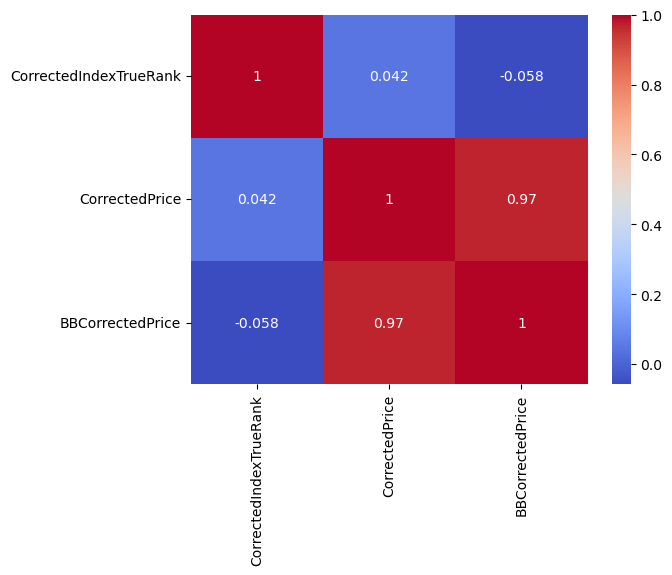

In [15]:
# You'll notice we have a lot of "clutter". We have some categories that aren't pertinent to what we're trying to interpret,
# such as the uncorrected versions of our data. We'll go ahead and simplify things by removing those.
cor_amazon = amazon[['CorrectedIndexTrueRank', 'CorrectedPrice', 'BBCorrectedPrice']]
sns.heatmap(cor_amazon.corr(), annot=True, cmap='coolwarm');

- As we can see here, there is barely a correlation between our BBCorrectedPrice and the Corrected Index True Rank. Similarly, we see a very small correlation between corrected index true rank and the corrected price. This suggests that the prices and their rank do not have a correlation, supporting our null hypothesis that there's no correlation between rank and price. 
- While it would be nice to try to interpret between price and BB price, this doesn't exactly accomplish this. Since for that, we want to answer the question of how different price and BB price are on average, we'd need to use a different statistical analysis. 

### Building Our Models

- Next, we're going to try to build a model to try and predict our dependent variable (Corrected Index True Rank) based off our independent variables (Corrected Price and BB Corrected Price). We'll attempt this with a linear regression model first. 

In [16]:
# Going to run a linear regression model with BBCorrected Price and Corrected
# Price as our independent variables, and Corrected Index True Rank as our 
# dependent variable

# Make our independent variable into a dataframe
feature_cols = ['CorrectedPrice', 'BBCorrectedPrice']
# Make it into an array
X = amazon[feature_cols]
# Make our dependent variable, or target variable, into an array
y = amazon['CorrectedIndexTrueRank']
# Shortcut our LinearRegression name
lr = LinearRegression()

# Split our model so we have 70% training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 42)

# Create a NumPy array with same shape as y_train
y_null = np.zeros_like(y_train, dtype=float)

# Fill array with mean value of y_train
y_null.fill(y_train.mean())

# Fit/train our model to learn the relationship between x and y
lr.fit(X_train,y_train)

# Predict our dependent variable
y_pred_test = lr.predict(X_test)
y_pred_train = lr.predict(X_train)

# Calculate our R-squared score
print("R2 Score for Test Data:", r2_score(y_test, y_pred_test))
print("R2 Score for Training Data:", r2_score(y_train, y_pred_train))
print("R2 Score for Null Data:", r2_score(y_train, y_null))
print("******************")
#Calculate our RMSE
print("RMSE for Test Data:", mean_squared_error(y_test, y_pred_test, squared = False))
print("RMSE for Training Data:", mean_squared_error(y_train, y_pred_train, squared = False))
print("RMSE for Null Data:", mean_squared_error(y_train, y_null, squared = False))

R2 Score for Test Data: 0.16114325160546494
R2 Score for Training Data: 0.15627531106989268
R2 Score for Null Data: 0.0
******************
RMSE for Test Data: 17.8176085767377
RMSE for Training Data: 17.471618746767895
RMSE for Null Data: 19.02097459398383


- According to our results, our R-squared value is low, meaning that our independent variables doesn't seem to have much of an impact on the variation of  our depedendent variable. In other words, it seems the corrected price and BB corrected price doesn't seem to be influencing much the variation in the corrected index true rank. 
-  While our R squared value for our training data is low, it's still much higher than the R squared value for our null data, which means that our model learned, and is still better than if we hadn't done anything to train the model.
- Our R squared scores for the training and test data are very similar, indicating we don't have as much of a variance problem. Our scores were low though, indicating we have a bias problem. In short, our model seems to have more of a bias problem than a variance problem. 
- Our RMSE are high, indicating that our model doesn't seem to make that accurate of predictions, and our model wouldn't be as accurate for predictions.
- So, it looks like we'll need to improve our model somewhat. One way is adding more feature columns. We'll achieve this by dummifying our BBVendorType. This is a good column to choose since there aren't too many different values, and it'd be useful to try and see if vendor types (Amazon, FBA, and Other) helps predict index rank.   

In [17]:
# Dummify our data
dummy_amazon = pd.get_dummies(amazon["BBVendorType"], prefix = 'BBVendorType', drop_first=True)
# Add our dummy columns to dataframe
amazon = pd.concat([amazon, dummy_amazon], axis=1)
# Drop the original column
amazon = amazon.drop(columns = ["BBVendorType"])
# Look at our data
amazon.head()

,Index,ProductName,ScrapeDate,ScrapedIndex,ScrapedIndexTrueRank,CorrectedIndexTrueRank,ScrapedIndexPrice,CorrectedPrice,ScrapedIndexVendor,ScrapedIndexVendorType,BBScrapedPrice,BBVendor,BBCorrectedPrice,BBVendorType_FBA,BBVendorType_O
0,0,#1 BEST Probiotic Supplement - 60 Day Supply w...,2016-06-14,2,2,1,20.99,20.99,Supplement Warriors,Other,-1.0,Sold by Sharp Nutrition and Fulfilled by Amazon.,25.02,True,False
1,1,#1 BEST Probiotic Supplement - 60 Day Supply w...,2016-06-14,1,1,2,19.99,25.02,Sharp Nutrition,FBA,-1.0,Sold by Sharp Nutrition and Fulfilled by Amazon.,25.02,True,False
2,2,"10 Panel Dip Drug Testing Kit, Test for 10 Dif...",2016-06-27,1,1,1,3.96,3.96,speedy tests,Other,4.9,Sold by Michael Minyety and Fulfilled by Amazon.,9.97,True,False
3,3,"10 Panel Dip Drug Testing Kit, Test for 10 Dif...",2016-06-27,2,1,1,3.96,3.96,Drug Abuse Control,Other,4.9,Sold by Michael Minyety and Fulfilled by Amazon.,9.97,True,False
4,4,"10 Panel Dip Drug Testing Kit, Test for 10 Dif...",2016-06-27,3,1,1,3.96,3.96,Lowest Priced Tests,Other,4.9,Sold by Michael Minyety and Fulfilled by Amazon.,9.97,True,False


In [18]:
# Run our linear regression model again, but this time with BBVendorType as part of our feature columns this time
# Want to see if this improves our model's predictive power

# Make our independent variable into a dataframe
feature_cols = ['CorrectedPrice', 'BBCorrectedPrice', 'BBVendorType_FBA', 'BBVendorType_O']
# Make it into an array
X = amazon[feature_cols]
# Make our dependent variable, or target variable, into an array
y = amazon['CorrectedIndexTrueRank']
# Shortcut our LinearRegression name
lr = LinearRegression()

# Split our model so we have 70% training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 42)

# Create a NumPy array with same shape as y_train
y_null = np.zeros_like(y_train, dtype=float)

# Fill array with mean value of y_train
y_null.fill(y_train.mean())

# Fit/train our model to learn the relationship between x and y
lr.fit(X_train,y_train)

# Predict our dependent variable
y_pred_test = lr.predict(X_test)
y_pred_train = lr.predict(X_train)

# Calculate our R-squared score
print("R2 Score for Test Data:", r2_score(y_test, y_pred_test))
print("R2 Score for Training Data:", r2_score(y_train, y_pred_train))
print("R2 Score for Null Data:", r2_score(y_train, y_null))
print("******************")
#Calculate our RMSE
print("RMSE for Test Data:", mean_squared_error(y_test, y_pred_test, squared = False))
print("RMSE for Training Data:", mean_squared_error(y_train, y_pred_train, squared = False))
print("RMSE for Null Data:", mean_squared_error(y_train, y_null, squared = False))

R2 Score for Test Data: 0.20674611342113702
R2 Score for Training Data: 0.20605898868994355
R2 Score for Null Data: 0.0
******************
RMSE for Test Data: 17.326530880932207
RMSE for Training Data: 16.948328908712707
RMSE for Null Data: 19.02097459398383


- So as a result of dummifying our BBVendorType column, our R2 score got slightly better! Not only did it increase, but they're similar, meaning both the bias and the variance improved. It wasn't a lot, but nonetheless it improved the model.

- Now, we'll switch gears and see if we can get a better R2 score with a different model. We'll go with random forest.

- First, we'll do a gridsearch CV to try to find our best hyperparameters (speficially, find our best max features and n_estimators)

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
# Set up the hyperparameters we want to loop through to try
params_grids = {
    'n_estimators' : [1, 5, 10, 15, 20, 25, 150],
    'max_features' : [1, 2, 3, 5, 10],
}

# Set up our random state, increase the amount of CPU we dedicate to this
gs = GridSearchCV(
    estimator = RandomForestClassifier(random_state=42),
    param_grid = params_grids,
    cv = 10,
    n_jobs = 8
)

# Fit everything
gs.fit(X_train, y_train)

# Print our best hyperparameters and the score
print("Best Parameters:",gs.best_params_)
print("Best score:",gs.best_score_)

C:\Users\Paulm\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Best Parameters: {'max_features': 5, 'n_estimators': 25}
Best score: 0.17045744074558317


- It says our best features should be max_features 5 and we should have estimators set to 25, so we'll do just that. 

In [20]:
# Set up our random forest with our suggested hyperparameters, and output
# an oob score
rf = RandomForestRegressor(max_features=5, n_estimators=25, oob_score=True, random_state=42)
rf.fit(X, y)
print("Out of bag R2 score:", rf.oob_score_)

# Find the average RMSE.
scores = cross_val_score(rf, X, y, cv=10, scoring='neg_mean_squared_error')
print("Average RMSE:",np.mean((-scores) ** 0.5)) 

Out of bag R2 score: 0.936139945756827
Average RMSE: 19.371000655635854


- Here we get a much better R2 score than our linear regression model, showing us that random forest was the way to go! What is a little confusing is that we have a high average RMSE still. 
- By sheer chance, when I ran this for the first time with a higher estimator, I got a slightly better R2 score, which I think is just due to chance. Either way, after playing around with estimators and the max features, it seems that estimators don't seem to play too much of a difference.

In [21]:
# Do the same thing again but with estimators set to 150
rf = RandomForestRegressor(max_features=5, n_estimators=150, oob_score=True, random_state=42)
rf.fit(X, y)
print("Out of bag R2 score:", rf.oob_score_)

# Find the average RMSE.
scores = cross_val_score(rf, X, y, cv=10, scoring='neg_mean_squared_error')
print("Average RMSE:",np.mean((-scores) ** 0.5))

Out of bag R2 score: 0.9465789542965835
Average RMSE: 19.354888968012805


### Final Remarks

- In conclusion, our linear regression model was not very good at predicting Corrected Index True Rank even with additional independent variables. The random forest was definitely the better option for our dataset, with a much higher R2 score, suggesting it is much better at predicting our dependent variable based off our independent variables. So, to conclude all of our findings, if we want to make predictions about Amazon's index rankings for its top 250 products, we want to use a random forest model. 

- Considering the limitations I mentioned before, I don't believe this model would be very applicable to broader Amazon data. For the future, I would build a model that included much more data, across many different industries, randomly select thousands of products, and have data from every possible year to try to make a better model than the one I have built. 